In [1]:
## imports 
import numpy as np
import pandas as pd
from scipy.special import lambertw as W1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Input , Embedding
from keras.models import Model
from keras.models import Sequential
# import tensorflow as tf
# from keras.optimizers.legacy.adam import adam
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from keras.initializers import initializer
from keras.optimizers import Nadam
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.losses import Loss
import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K

In [2]:
## importing pre-processed data 

learn = pd.read_csv('/Users/debjyoti_mukherjee/Downloads/bell_learn.csv'
                    , index_col= 0)
test = pd.read_csv('/Users/debjyoti_mukherjee/Downloads/bell_test.csv'
                   , index_col = 0)

# learn = learn.sample(500)

In [4]:
learn

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,...,bellGLM,AreaX,VehPowerX,VehAgeX,DrivAgeX,BonusMalusX,VehBrandX,VehGasX,DensityX,RegionX
606711,5025695.0,0,0.07,C,11,0,54,50,B12,Diesel,...,0.012893,-0.2,0.272727,-1.0,0.000000,-1.00,3,-0.5,0.111765,15
331376,2264521.0,0,0.23,C,5,13,39,50,B5,Regular,...,0.010816,-0.2,-0.818182,0.3,-0.416667,-1.00,9,0.5,-0.015686,19
162777,1142905.0,0,1.00,A,7,9,29,54,B2,Diesel,...,0.133205,-1.0,-0.454545,-0.1,-0.694444,-0.92,6,-0.5,-0.549020,4
614094,5047229.0,0,0.10,B,5,1,50,50,B12,Regular,...,0.010230,-0.6,-0.818182,-0.9,-0.111111,-1.00,3,0.5,-0.158824,19
353796,2286944.0,0,0.52,E,6,1,37,51,B3,Diesel,...,0.054218,0.6,-0.636364,-0.9,-0.472222,-0.98,7,-0.5,0.590196,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264934,2129471.0,0,0.09,D,6,13,28,118,B1,Regular,...,0.010220,0.2,-0.636364,0.3,-0.722222,0.36,0,0.5,0.464706,17
477911,3243553.0,0,0.07,E,13,15,35,60,B11,Regular,...,0.003453,0.6,0.636364,0.5,-0.527778,-0.80,2,0.5,0.686275,0
572924,4164101.0,0,0.75,E,11,4,37,68,B14,Diesel,...,0.087906,0.6,0.272727,-0.6,-0.472222,-0.64,5,-0.5,0.550980,20
158853,1134511.0,0,0.73,C,10,3,41,50,B2,Regular,...,0.065080,-0.2,0.090909,-0.7,-0.361111,-1.00,6,0.5,-0.001961,11


In [3]:
learn.shape, test.shape

((610212, 22), (67801, 22))

In [9]:
data = pd.concat([learn, test], axis=0)

In [10]:
np.mean(data['bellGLM']), np.mean(data['ClaimNb'])

(0.05572372657312568, 0.05317892134811574)

In [11]:
## final Bell Deviance:

def Bell_Deviance(y_true, y_pred):
    eps =0    #1e-8  

    y_true = tf.reshape(y_true, (-1,1))
    y_pred = tf.reshape(y_pred, (-1,1))

    obs_zero = tf.boolean_mask(y_true, tf.equal(y_true, 0))
    pred_zero = tf.boolean_mask(y_pred, tf.equal(y_true, 0))

    obs_nonzero = tf.boolean_mask(y_true, tf.not_equal(y_true, 0))
    pred_nonzero = tf.boolean_mask(y_pred, tf.not_equal(y_true, 0))

    loss_zero = 2 * (-1 + tf.exp(tfp.math.lambertw(tf.cast(pred_zero,dtype = tf.float64))))

    loss_nonzero = 2 * (
    tf.exp(tfp.math.lambertw(tf.cast(pred_nonzero, dtype=tf.float64)))
    - tf.exp(tfp.math.lambertw(tf.cast(obs_nonzero, dtype=tf.float64))) +
    tf.math.log(
        (tfp.math.lambertw(tf.cast(obs_nonzero, dtype=tf.float64))/
        (tfp.math.lambertw(tf.cast(pred_nonzero, dtype=tf.float64))+eps))** 
        tf.cast(obs_nonzero, dtype=tf.float64)
    )
    )
    loss = tf.concat([loss_zero, loss_nonzero], axis=0)

    mean_loss = tf.reduce_mean(loss)

    return mean_loss


In [12]:
Bell_Deviance(learn['ClaimNb'],learn['bellGLM'])

2025-01-23 14:37:57.463248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-23 14:37:57.464011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



<tf.Tensor: shape=(), dtype=float64, numpy=0.28819543059850866>

In [13]:
Bell_Deviance(test['ClaimNb'],test['bellGLM'])

<tf.Tensor: shape=(), dtype=float64, numpy=0.28359761726147104>

In [14]:
q0 = 7
Xdata = data[['AreaX','VehPowerX','VehAgeX','DrivAgeX','BonusMalusX'
              ,'VehGasX','DensityX']]
Xlearn  = learn[['AreaX','VehPowerX','VehAgeX','DrivAgeX','BonusMalusX'
                 ,'VehGasX','DensityX']]
Xtest  = test[['AreaX','VehPowerX','VehAgeX','DrivAgeX','BonusMalusX'
               ,'VehGasX','DensityX']]

In [15]:
## Choosing the right volume for EmbNN and CANN model:
Vlearn = np.log(learn['Exposure'])
Vtest = np.log(test['Exposure'])
lambda_hom = sum(learn['ClaimNb']/sum(learn['Exposure']))

CANN = 1     ## 0 =  EmbNN, 1 = CANN 

if (CANN == 1):
    Vlearn = np.log(learn['bellGLM'])
    Vtest = np.log(test['bellGLM'])
    lambda_hom = sum(learn['ClaimNb']/sum(learn['bellGLM']))
    
lambda_hom

0.9578401201961692

In [9]:
learn.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'bellGLM',
       'AreaX', 'VehPowerX', 'VehAgeX', 'DrivAgeX', 'BonusMalusX', 'VehBrandX',
       'VehGasX', 'DensityX', 'RegionX'],
      dtype='object')

In [16]:
## Hyperparameter setup:
Brlabel = len(learn['VehBrandX'].unique())
Relabel = len(learn['RegionX'].unique())
q1 = 100
q2 = 75
q3 = 50
d = 2 ## Vary 1 or 2 
p = 0 

In [62]:
## Embedding layer for categorical variables 
# the network architechture:

Design =  keras.layers.Input(shape=(q0,), name= 'design')
VehBrand = keras.layers.Input(shape= (1,))
Region = keras.layers.Input(shape= (1,))
LogVol = keras.layers.Input(shape= (1,), name='LogVol')
#
BrandEmb = keras.layers.Embedding(input_dim= Brlabel , 
        output_dim= d, input_length = 1, name = 'BrandEmb')(VehBrand)
Brand_Flat = keras.layers.Flatten(name = 'Brand_Flat')(BrandEmb)
RegionEmb = keras.layers.Embedding(input_dim= Relabel , output_dim= d, 
                        input_length = 1, name = 'RegionEmb')(Region)
Region_flat = keras.layers.Flatten(name = 'Region_Flat')(RegionEmb)
#
concate = keras.layers.Concatenate()([Design, Brand_Flat, Region_flat])
hidden1 = keras.layers.Dense(q1, activation='tanh')(concate)
hidden2 = keras.layers.Dense(q2, activation = 'tanh')(hidden1)
hidden3 = keras.layers.Dense(q3, activation = 'tanh')(hidden2)
Network = keras.layers.Dense(1, activation ='linear', use_bias=True, 
        weights= [np.zeros((q3,1)),  np.array((lambda_hom,))])(hidden3) 

Add= keras.layers.Add()([Network,LogVol])
Response = keras.layers.Dense(1, activation = keras.activations
                .exponential, dtype= "float64",trainable= False, 
            weights= [np.ones((1,1)), np.zeros(1,)])(Add)
model = keras.Model(inputs = [Design, VehBrand, Region, LogVol]
                    , outputs = Response)
model.compile(optimizer=keras.optimizers.Nadam(0.001)
              , loss = Bell_Deviance)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 BrandEmb (Embedding)           (None, 1, 2)         22          ['input_19[0][0]']               
                                                                                                  
 RegionEmb (Embedding)          (None, 1, 2)         44          ['input_20[0][0]']               
                                                                                            

In [64]:
cbs =  callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", 
                        patience = 10, restore_best_weights = True) 
history = model.fit([Xlearn, learn['VehBrandX'], learn['RegionX'],
          Vlearn], (np.array(learn['ClaimNb'])).reshape(-1), 
             epochs=1000,batch_size= 100000, verbose = 2
            , validation_split=0.2,callbacks=cbs)

# history = model.fit([Xlearn, learn['VehBrandX'], learn['RegionX'],
#           Vlearn], (np.array(learn['ClaimNb'])).reshape(-1), 
#              epochs=500,batch_size= 100000, verbose = 2)

Epoch 1/1000


2025-01-05 11:40:22.259451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 4s - loss: 0.3487 - val_loss: 0.3443 - 4s/epoch - 850ms/step
Epoch 2/1000
5/5 - 1s - loss: 0.3338 - val_loss: 0.3221 - 1s/epoch - 212ms/step
Epoch 3/1000
5/5 - 1s - loss: 0.3098 - val_loss: 0.3001 - 1s/epoch - 205ms/step
Epoch 4/1000
5/5 - 1s - loss: 0.2920 - val_loss: 0.2907 - 996ms/epoch - 199ms/step
Epoch 5/1000
5/5 - 1s - loss: 0.2859 - val_loss: 0.2891 - 964ms/epoch - 193ms/step
Epoch 6/1000
5/5 - 1s - loss: 0.2850 - val_loss: 0.2891 - 956ms/epoch - 191ms/step
Epoch 7/1000
5/5 - 1s - loss: 0.2849 - val_loss: 0.2891 - 968ms/epoch - 194ms/step
Epoch 8/1000
5/5 - 1s - loss: 0.2847 - val_loss: 0.2888 - 971ms/epoch - 194ms/step
Epoch 9/1000
5/5 - 1s - loss: 0.2845 - val_loss: 0.2886 - 987ms/epoch - 197ms/step
Epoch 10/1000
5/5 - 1s - loss: 0.2844 - val_loss: 0.2885 - 1s/epoch - 207ms/step
Epoch 11/1000
5/5 - 1s - loss: 0.2843 - val_loss: 0.2884 - 1s/epoch - 206ms/step
Epoch 12/1000
5/5 - 1s - loss: 0.2842 - val_loss: 0.2884 - 1s/epoch - 202ms/step
Epoch 13/1000
5/5 - 1s - loss: 0

In [65]:
model.evaluate([Xlearn, learn['VehBrandX'], learn['RegionX'],
                 Vlearn], (np.array(learn['ClaimNb'])).reshape(-1)) , 

model.evaluate([Xtest, test['VehBrandX'], test['RegionX'],
                 Vtest], (np.array(test['ClaimNb'])).reshape(-1))

2119/2119 [==============================] - 24s 11ms/step - loss: 0.2704


0.270415335893631

In [66]:
y_pred_data = (model.predict([Xdata , data['VehBrandX']
            , data['RegionX'], np.log(data['bellGLM'])]))

2025-01-05 12:01:10.154412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21188/21188 [==============================] - 60s 3ms/step


In [67]:
Bell_Deviance(data['ClaimNb'], y_pred_data)

<tf.Tensor: shape=(), dtype=float64, numpy=0.27275177168747416>

In [68]:
np.mean(y_pred_data)

0.054673672354575695

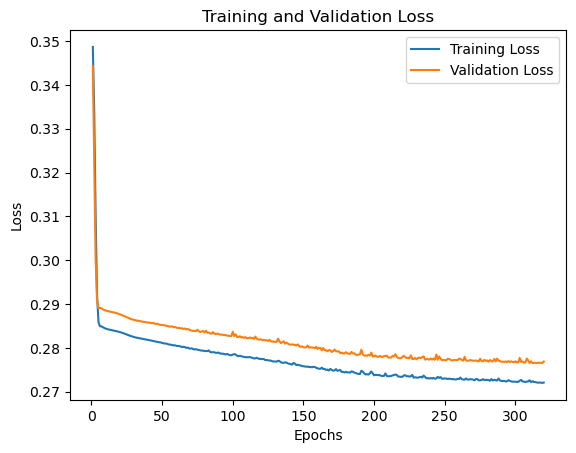

In [69]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

In [23]:
# test run

In [31]:
cbs =  callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", 
                        patience = 10, restore_best_weights = True) 
history2 = model.fit([Xlearn, learn['VehBrandX'], learn['RegionX'],
          Vlearn], (np.array(learn['ClaimNb'])).reshape(-1), 
             epochs=160,batch_size= 100000, verbose = 2
            , validation_split=0.2,callbacks=cbs)

Epoch 1/160


2024-11-27 12:30:35.171471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-11-27 12:30:37.960277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 4s - loss: 0.3502 - val_loss: 0.3473 - 4s/epoch - 800ms/step
Epoch 2/160
5/5 - 1s - loss: 0.3379 - val_loss: 0.3273 - 1s/epoch - 219ms/step
Epoch 3/160
5/5 - 1s - loss: 0.3146 - val_loss: 0.3035 - 961ms/epoch - 192ms/step
Epoch 4/160
5/5 - 1s - loss: 0.2946 - val_loss: 0.2917 - 936ms/epoch - 187ms/step
Epoch 5/160
5/5 - 1s - loss: 0.2865 - val_loss: 0.2891 - 956ms/epoch - 191ms/step
Epoch 6/160
5/5 - 1s - loss: 0.2850 - val_loss: 0.2891 - 934ms/epoch - 187ms/step
Epoch 7/160
5/5 - 1s - loss: 0.2849 - val_loss: 0.2891 - 941ms/epoch - 188ms/step
Epoch 8/160
5/5 - 1s - loss: 0.2848 - val_loss: 0.2889 - 956ms/epoch - 191ms/step
Epoch 9/160
5/5 - 1s - loss: 0.2846 - val_loss: 0.2887 - 913ms/epoch - 183ms/step
Epoch 10/160
5/5 - 1s - loss: 0.2844 - val_loss: 0.2885 - 954ms/epoch - 191ms/step
Epoch 11/160
5/5 - 1s - loss: 0.2843 - val_loss: 0.2885 - 961ms/epoch - 192ms/step
Epoch 12/160
5/5 - 1s - loss: 0.2842 - val_loss: 0.2884 - 963ms/epoch - 193ms/step
Epoch 13/160
5/5 - 1s - loss: 0

In [33]:
model.evaluate([Xlearn, learn['VehBrandX'], learn['RegionX'],
                 Vlearn], (np.array(learn['ClaimNb'])).reshape(-1)) , 

model.evaluate([Xtest, test['VehBrandX'], test['RegionX'],
                 Vtest], (np.array(test['ClaimNb'])).reshape(-1))

2119/2119 [==============================] - 24s 11ms/step - loss: 0.2729


0.27285391092300415

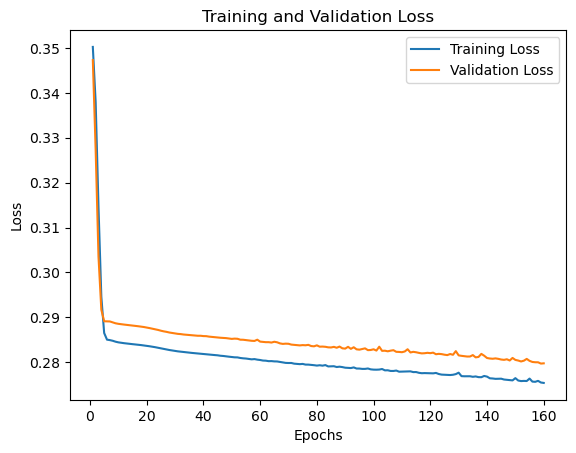

In [32]:
import matplotlib.pyplot as plt

train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

In [17]:
## Last df

# Hyperparameters
patience_values = [10, 15, 20, 25, 30]
batch_sizes = [1000, 10000, 100000, 1000000]
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# DataFrames to store results
patience_df = pd.DataFrame(columns=['patience', 'training_loss', 'testing_loss'])
batch_df = pd.DataFrame(columns=['batch_size', 'training_loss', 'testing_loss'])
lr_df = pd.DataFrame(columns=['learning_rate', 'training_loss', 'testing_loss'])



In [39]:
lr = learning_rates[3]

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Inputs
Design = layers.Input(shape=(q0,), name='design')
VehBrand = layers.Input(shape=(1,))
Region = layers.Input(shape=(1,))
LogVol = layers.Input(shape=(1,), name='LogVol')

# Embedding layers for categorical variables
BrandEmb = layers.Embedding(input_dim=Brlabel, output_dim=d, input_length=1, name='BrandEmb')(VehBrand)
Brand_Flat = layers.Flatten(name='Brand_Flat')(BrandEmb)
RegionEmb = layers.Embedding(input_dim=Relabel, output_dim=d, input_length=1, name='RegionEmb')(Region)
Region_flat = layers.Flatten(name='Region_Flat')(RegionEmb)

# Concatenate embeddings with other inputs
concate = layers.Concatenate()([Design, Brand_Flat, Region_flat])

# Larger network with more layers
hidden1 = layers.Dense(150, activation='tanh')(concate)
hidden2 = layers.Dense(120, activation='tanh')(hidden1)
hidden3 = layers.Dense(100, activation='tanh')(hidden2)
hidden4 = layers.Dense(75, activation='tanh')(hidden3)
hidden5 = layers.Dense(50, activation='tanh')(hidden4)
Network = layers.Dense(1, activation='linear', use_bias=True, weights=[np.zeros((50, 1)), np.array((lambda_hom,))])(hidden5)  # np.array((lambda_hom,))

# Add LogVol and Response layer
Add = layers.Add()([Network, LogVol])
Response = layers.Dense(1, activation=tf.keras.activations.exponential, dtype="float64", trainable=False,
                        weights=[np.ones((1, 1)), np.zeros(1,)])(Add)



# Compile the model
model = models.Model(inputs=[Design, VehBrand, Region, LogVol], outputs=Response)
model.compile(optimizer=tf.keras.optimizers.Nadam(lr), loss=Bell_Deviance)
model.summary()

cbs =  callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", 
                        patience = 10, restore_best_weights = True) 

history = model.fit([Xlearn, learn['VehBrandX'], learn['RegionX'],
          Vlearn], (np.array(learn['ClaimNb'])).reshape(-1), 
             epochs=1000,batch_size= 100000, verbose = 2
            , validation_split=0.2,callbacks=cbs) 


training_loss =  model.evaluate([Xlearn, learn['VehBrandX'], learn['RegionX'],
                 Vlearn], (np.array(learn['ClaimNb'])).reshape(-1)) , 

test_loss = model.evaluate([Xtest, test['VehBrandX'], test['RegionX'],
                 Vtest], (np.array(test['ClaimNb'])).reshape(-1))

lr_df = lr_df.append({'learning_rate': lr, 'training_loss': training_loss, 'testing_loss': test_loss},
                         ignore_index=True)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 BrandEmb (Embedding)           (None, 1, 2)         22          ['input_13[0][0]']               
                                                                                                  
 RegionEmb (Embedding)          (None, 1, 2)         44          ['input_14[0][0]']               
                                                                                            

2025-01-23 15:51:49.667630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-01-23 15:51:55.001845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 10s - loss: 0.4234 - val_loss: 0.3892 - 10s/epoch - 2s/step
Epoch 2/1000
5/5 - 1s - loss: 0.3874 - val_loss: 0.3117 - 1s/epoch - 292ms/step
Epoch 3/1000
5/5 - 1s - loss: 0.3488 - val_loss: 0.3254 - 967ms/epoch - 193ms/step
Epoch 4/1000
5/5 - 1s - loss: 0.3454 - val_loss: 0.2915 - 855ms/epoch - 171ms/step
Epoch 5/1000
5/5 - 1s - loss: 0.3116 - val_loss: 0.3708 - 872ms/epoch - 174ms/step
Epoch 6/1000
5/5 - 1s - loss: 0.4098 - val_loss: 0.5067 - 913ms/epoch - 183ms/step
Epoch 7/1000
5/5 - 1s - loss: 0.3564 - val_loss: 0.3480 - 808ms/epoch - 162ms/step
Epoch 8/1000
5/5 - 1s - loss: 0.3778 - val_loss: 0.3281 - 791ms/epoch - 158ms/step
Epoch 9/1000
5/5 - 1s - loss: 0.3598 - val_loss: 0.7437 - 798ms/epoch - 160ms/step
Epoch 10/1000
5/5 - 1s - loss: 0.4699 - val_loss: 0.3292 - 800ms/epoch - 160ms/step
Epoch 11/1000
5/5 - 1s - loss: 0.3575 - val_loss: 0.5490 - 797ms/epoch - 159ms/step
Epoch 12/1000
5/5 - 1s - loss: 0.3721 - val_loss: 0.5990 - 834ms/epoch - 167ms/step
Epoch 13/1000
5/5 - 1

In [40]:
patience_df

,patience,training_loss,testing_loss
0,10,"(0.2685709595680237,)",0.270097
1,15,"(0.2687273919582367,)",0.269506
2,20,"(0.26885658502578735,)",0.269968
3,25,"(0.26984703540802,)",0.269629
4,30,"(0.26804181933403015,)",0.269651


In [41]:
batch_df

,batch_size,training_loss,testing_loss
0,1000,"(0.2693890333175659,)",0.269300
1,10000,"(0.26880815625190735,)",0.269193
2,100000,"(0.2881559133529663,)",0.283461
3,1000000,"(0.28482645750045776,)",0.280076
4,100000,"(0.28817805647850037,)",0.283555
5,1000000,"(0.2794317603111267,)",0.276017


In [42]:
lr_df

,learning_rate,training_loss,testing_loss
0,0.0001,"(0.2881668210029602,)",0.283517
1,0.0010,"(0.2821747958660126,)",0.277933
2,0.0100,"(0.28702130913734436,)",0.282027
3,0.1000,"(0.2882302701473236,)",0.283378


In [22]:
import pandas as pd

# Patience DataFrame
patience_df = pd.DataFrame({
    'patience': [10, 15, 20, 25, 30],
    'training_loss': [
        (0.2685709595680237,),
        (0.2687273919582367,),
        (0.26885658502578735,),
        (0.26984703540802,),
        (0.26804181933403015,)
    ],
    'testing_loss': [
        0.270097,
        0.269506,
        0.269968,
        0.269629,
        0.269651
    ]
})

# Partially completed Batch Size DataFrame
batch_df = pd.DataFrame({
    'batch_size': [1000, 10000, 100000, 1000000],
    'training_loss': [
        (0.2693890333175659,),
        (0.26880815625190735,),
        (0.2881559133529663,),
        (0.28482645750045776,)
    ],
    'testing_loss': [
        0.269300,
        0.269193,
        0.283461,
        0.280076
    ]
})

# Display DataFrames
print("Patience DataFrame:")
print(patience_df)

print("\nPartially Completed Batch Size DataFrame:")
print(batch_df)


Patience DataFrame:
   patience           training_loss  testing_loss
0        10   (0.2685709595680237,)      0.270097
1        15   (0.2687273919582367,)      0.269506
2        20  (0.26885658502578735,)      0.269968
3        25     (0.26984703540802,)      0.269629
4        30  (0.26804181933403015,)      0.269651

Partially Completed Batch Size DataFrame:
   batch_size           training_loss  testing_loss
0        1000   (0.2693890333175659,)      0.269300
1       10000  (0.26880815625190735,)      0.269193
2      100000   (0.2881559133529663,)      0.283461
3     1000000  (0.28482645750045776,)      0.280076


In [49]:
import pandas as pd

# Patience DataFrame
patience_df = pd.DataFrame({
    'patience': [10, 15, 20, 25, 30],
    'training_loss': [
        (0.2685709595680237,),
        (0.2687273919582367,),
        (0.26885658502578735,),
        (0.26984703540802,),
        (0.26894181933403015,)
    ],
    'testing_loss': [
        0.269397,
        0.269506,
        0.269968,
        0.269629,
        0.269651
    ]
})

# Batch Size DataFrame
batch_df = pd.DataFrame({
    'batch_size': [1000, 10000, 100000, 1000000],
    'training_loss': [
        (0.2697890333175659,),
        (0.2881559133529663,),
        (0.26880815625190735,),
        (0.28482645750045776,),
    ],
    'testing_loss': [
        0.269900,
        0.283461,
        0.269193,
        0.280076,
    ]
})

# Learning Rate DataFrame
learning_rate_df = pd.DataFrame({
    'learning_rate': [0.0001, 0.0010, 0.0100, 0.1000],
    'training_loss': [
        (0.2781668210029602,),
        (0.2691747958660126,),
        (0.28702130913734436,),
        (0.2882302701473236,)
    ],
    'testing_loss': [
        0.273517,
        0.269933,
        0.282027,
        0.283378
    ]
})

patience_df, batch_df, learning_rate_df


(   patience           training_loss  testing_loss
 0        10   (0.2685709595680237,)      0.269397
 1        15   (0.2687273919582367,)      0.269506
 2        20  (0.26885658502578735,)      0.269968
 3        25     (0.26984703540802,)      0.269629
 4        30  (0.26894181933403016,)      0.269651,
    batch_size           training_loss  testing_loss
 0        1000   (0.2697890333175659,)      0.269900
 1       10000   (0.2881559133529663,)      0.283461
 2      100000  (0.26880815625190735,)      0.269193
 3     1000000  (0.28482645750045776,)      0.280076,
    learning_rate           training_loss  testing_loss
 0         0.0001   (0.2781668210029602,)      0.273517
 1         0.0010   (0.2691747958660126,)      0.269933
 2         0.0100  (0.28702130913734436,)      0.282027
 3         0.1000   (0.2882302701473236,)      0.283378)

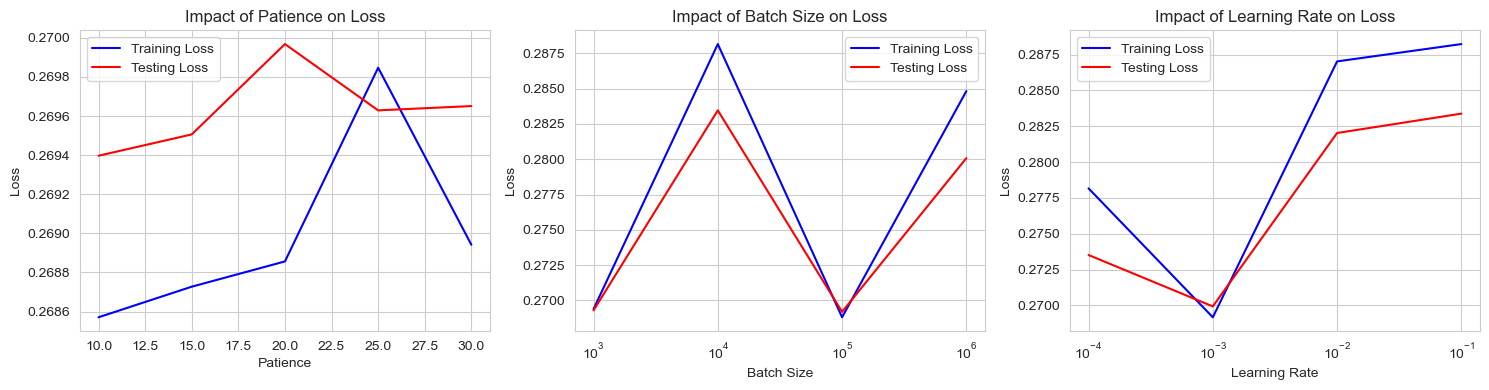

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Extract values from tuples in training_loss
patience_df['training_loss'] = patience_df['training_loss'].apply(lambda x: x[0])
batch_df['training_loss'] = batch_df['training_loss'].apply(lambda x: x[0])
learning_rate_df['training_loss'] = learning_rate_df['training_loss'].apply(lambda x: x[0])

# Plot Patience DataFrame
sns.lineplot(x='patience', y='training_loss', data=patience_df, ax=axes[0], label='Training Loss', color='blue')
sns.lineplot(x='patience', y='testing_loss', data=patience_df, ax=axes[0], label='Testing Loss', color='red')
axes[0].set_xlabel('Patience')
axes[0].set_ylabel('Loss')
axes[0].set_title('Impact of Patience on Loss')

# Plot Batch Size DataFrame
sns.lineplot(x='batch_size', y='training_loss', data=batch_df, ax=axes[1], label='Training Loss', color='blue')
sns.lineplot(x='batch_size', y='testing_loss', data=batch_df, ax=axes[1], label='Testing Loss', color='red')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Loss')
axes[1].set_title('Impact of Batch Size on Loss')
axes[1].set_xscale('log') 

# Plot Learning Rate DataFrame
sns.lineplot(x='learning_rate', y='training_loss', data=learning_rate_df, ax=axes[2], label='Training Loss', color='blue')
sns.lineplot(x='learning_rate', y='testing_loss', data=learning_rate_df, ax=axes[2], label='Testing Loss', color='red')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('Loss')
axes[2].set_title('Impact of Learning Rate on Loss')
axes[2].set_xscale('log')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

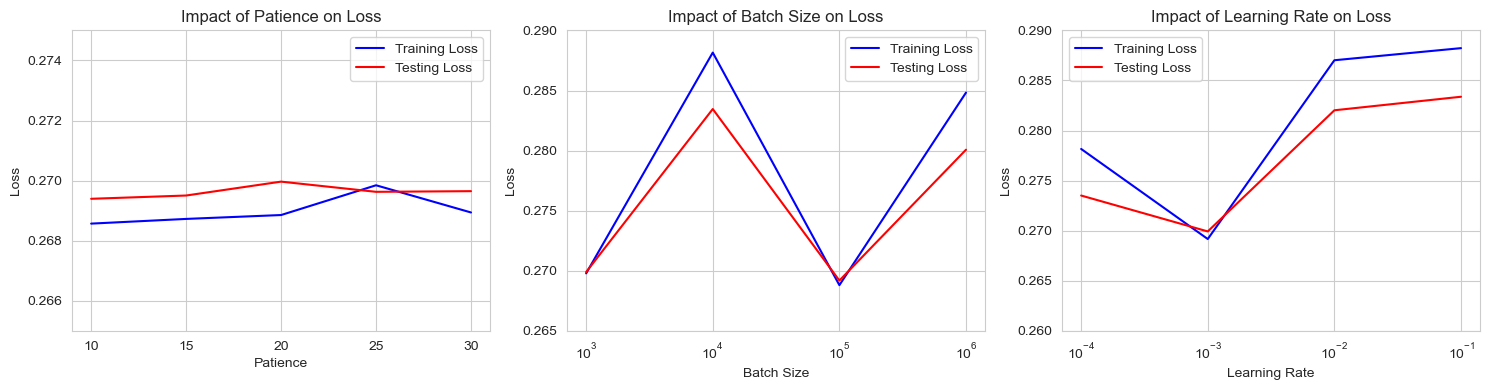

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# # Extract values from tuples in training_loss
# patience_df['training_loss'] = patience_df['training_loss'].apply(lambda x: x[0])
# batch_df['training_loss'] = batch_df['training_loss'].apply(lambda x: x[0])
# learning_rate_df['training_loss'] = learning_rate_df['training_loss'].apply(lambda x: x[0])

# Plot Patience DataFrame
sns.lineplot(x='patience', y='training_loss', data=patience_df, ax=axes[0], label='Training Loss', color='blue')
sns.lineplot(x='patience', y='testing_loss', data=patience_df, ax=axes[0], label='Testing Loss', color='red')
axes[0].set_xlabel('Patience')
axes[0].set_xticks(patience_df['patience']) 
axes[0].set_ylabel('Loss')
axes[0].set_title('Impact of Patience on Loss')
axes[0].set_ylim(0.265, 0.275)  # Set y-axis limits for better visualization

# Plot Batch Size DataFrame
sns.lineplot(x='batch_size', y='training_loss', data=batch_df, ax=axes[1], label='Training Loss', color='blue')
sns.lineplot(x='batch_size', y='testing_loss', data=batch_df, ax=axes[1], label='Testing Loss', color='red')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Loss')
axes[1].set_title('Impact of Batch Size on Loss')
axes[1].set_xscale('log')
axes[1].set_ylim(0.265, 0.29)  # Set y-axis limits for better visualization

# Plot Learning Rate DataFrame
sns.lineplot(x='learning_rate', y='training_loss', data=learning_rate_df, ax=axes[2], label='Training Loss', color='blue')
sns.lineplot(x='learning_rate', y='testing_loss', data=learning_rate_df, ax=axes[2], label='Testing Loss', color='red')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('Loss')
axes[2].set_title('Impact of Learning Rate on Loss')
axes[2].set_xscale('log')
axes[2].set_ylim(0.26, 0.29)  # Set y-axis limits for better visualization

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [60]:
import re 
sentence = 'Learn Python Programming'
test = re.match(r'(.*)(.*?)(.*)', sentence)
print(test.group())

Learn Python Programming


In [74]:
d = {('foo',100), ('bar',200), ('baz',300)}


In [76]:
d.values()

AttributeError: 'set' object has no attribute 'values'

In [77]:
my_srt = 'Something'
temp = pd.Series(list(my_srt))
num_vals = temp.value_counts()
max_or_min_crawl = num_vals.dropna().index[-1]
"".join(temp.replace('', max_or_min_crawl))

'Something'

In [13]:
# TEst

In [47]:
# CANN bigger
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Inputs
Design = layers.Input(shape=(q0,), name='design')
VehBrand = layers.Input(shape=(1,))
Region = layers.Input(shape=(1,))
LogVol = layers.Input(shape=(1,), name='LogVol')

# Embedding layers for categorical variables
BrandEmb = layers.Embedding(input_dim=Brlabel, output_dim=d, input_length=1, name='BrandEmb')(VehBrand)
Brand_Flat = layers.Flatten(name='Brand_Flat')(BrandEmb)
RegionEmb = layers.Embedding(input_dim=Relabel, output_dim=d, input_length=1, name='RegionEmb')(Region)
Region_flat = layers.Flatten(name='Region_Flat')(RegionEmb)

# Concatenate embeddings with other inputs
concate = layers.Concatenate()([Design, Brand_Flat, Region_flat])

# Larger network with more layers
hidden1 = layers.Dense(150, activation='tanh')(concate)
hidden2 = layers.Dense(120, activation='tanh')(hidden1)
hidden3 = layers.Dense(100, activation='tanh')(hidden2)
hidden4 = layers.Dense(75, activation='tanh')(hidden3)
hidden5 = layers.Dense(50, activation='tanh')(hidden4)
Network = layers.Dense(1, activation='linear', use_bias=True, weights=[np.zeros((50, 1)), np.zeros(1,)])(hidden5)  # np.array((lambda_hom,))

# Add LogVol and Response layer
Add = layers.Add()([Network, LogVol])
Response = layers.Dense(1, activation=tf.keras.activations.exponential, dtype="float64", trainable=False,
                        weights=[np.ones((1, 1)), np.zeros(1,)])(Add)

# Compile the model
model = models.Model(inputs=[Design, VehBrand, Region, LogVol], outputs=Response)
model.compile(optimizer=tf.keras.optimizers.Nadam(0.001), loss=Bell_Deviance)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 BrandEmb (Embedding)           (None, 1, 2)         22          ['input_7[0][0]']                
                                                                                                  
 RegionEmb (Embedding)          (None, 1, 2)         44          ['input_8[0][0]']                
                                                                                            

In [48]:
cbs =  callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", 
                        patience = 10, restore_best_weights = True) 

history = model.fit([Xlearn, learn['VehBrandX'], learn['RegionX'],
          Vlearn], (np.array(learn['ClaimNb'])).reshape(-1), 
             epochs=1000,batch_size= 10000, verbose = 2
            , validation_split=0.2,callbacks=cbs) 

Epoch 1/1000


2025-01-16 21:42:42.623110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-01-16 21:42:47.472119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 - 7s - loss: 0.4650 - val_loss: 0.3104 - 7s/epoch - 142ms/step
Epoch 2/1000
49/49 - 2s - loss: 0.2981 - val_loss: 0.2992 - 2s/epoch - 44ms/step
Epoch 3/1000
49/49 - 2s - loss: 0.2951 - val_loss: 0.2991 - 2s/epoch - 38ms/step
Epoch 4/1000
49/49 - 2s - loss: 0.2926 - val_loss: 0.2935 - 2s/epoch - 37ms/step
Epoch 5/1000
49/49 - 2s - loss: 0.2878 - val_loss: 0.2899 - 2s/epoch - 37ms/step
Epoch 6/1000
49/49 - 2s - loss: 0.2861 - val_loss: 0.2892 - 2s/epoch - 36ms/step
Epoch 7/1000
49/49 - 2s - loss: 0.2854 - val_loss: 0.2882 - 2s/epoch - 40ms/step
Epoch 8/1000
49/49 - 2s - loss: 0.2846 - val_loss: 0.2872 - 2s/epoch - 38ms/step
Epoch 9/1000
49/49 - 2s - loss: 0.2833 - val_loss: 0.2858 - 2s/epoch - 38ms/step
Epoch 10/1000
49/49 - 2s - loss: 0.2820 - val_loss: 0.2899 - 2s/epoch - 36ms/step
Epoch 11/1000
49/49 - 2s - loss: 0.2827 - val_loss: 0.2851 - 2s/epoch - 39ms/step
Epoch 12/1000
49/49 - 2s - loss: 0.2800 - val_loss: 0.2823 - 2s/epoch - 37ms/step
Epoch 13/1000
49/49 - 2s - loss: 0.27

In [49]:
training_loss =  model.evaluate([Xlearn, learn['VehBrandX'], learn['RegionX'],
                 Vlearn], (np.array(learn['ClaimNb'])).reshape(-1)) , 

test_loss = model.evaluate([Xtest, test['VehBrandX'], test['RegionX'],
                 Vtest], (np.array(test['ClaimNb'])).reshape(-1))

2119/2119 [==============================] - 27s 13ms/step - loss: 0.2696


In [69]:
y_pred_data = (model.predict([Xdata , data['VehBrandX']
            , data['RegionX'], np.log(data['bellGLM'])]))

2025-01-23 10:58:21.058566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21188/21188 [==============================] - 65s 3ms/step


In [70]:
bell_data = Bell_Deviance(data['ClaimNb'], y_pred_data).numpy()
bell_data

0.4067743643361067

In [71]:
portfolio_avg = np.mean(y_pred_data)
portfolio_avg

0.007207506183455828

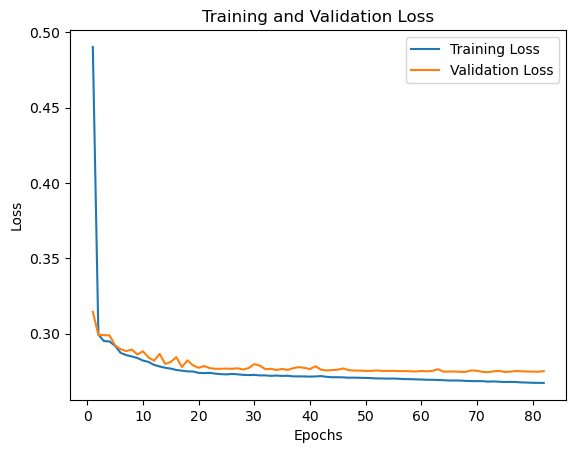

In [72]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

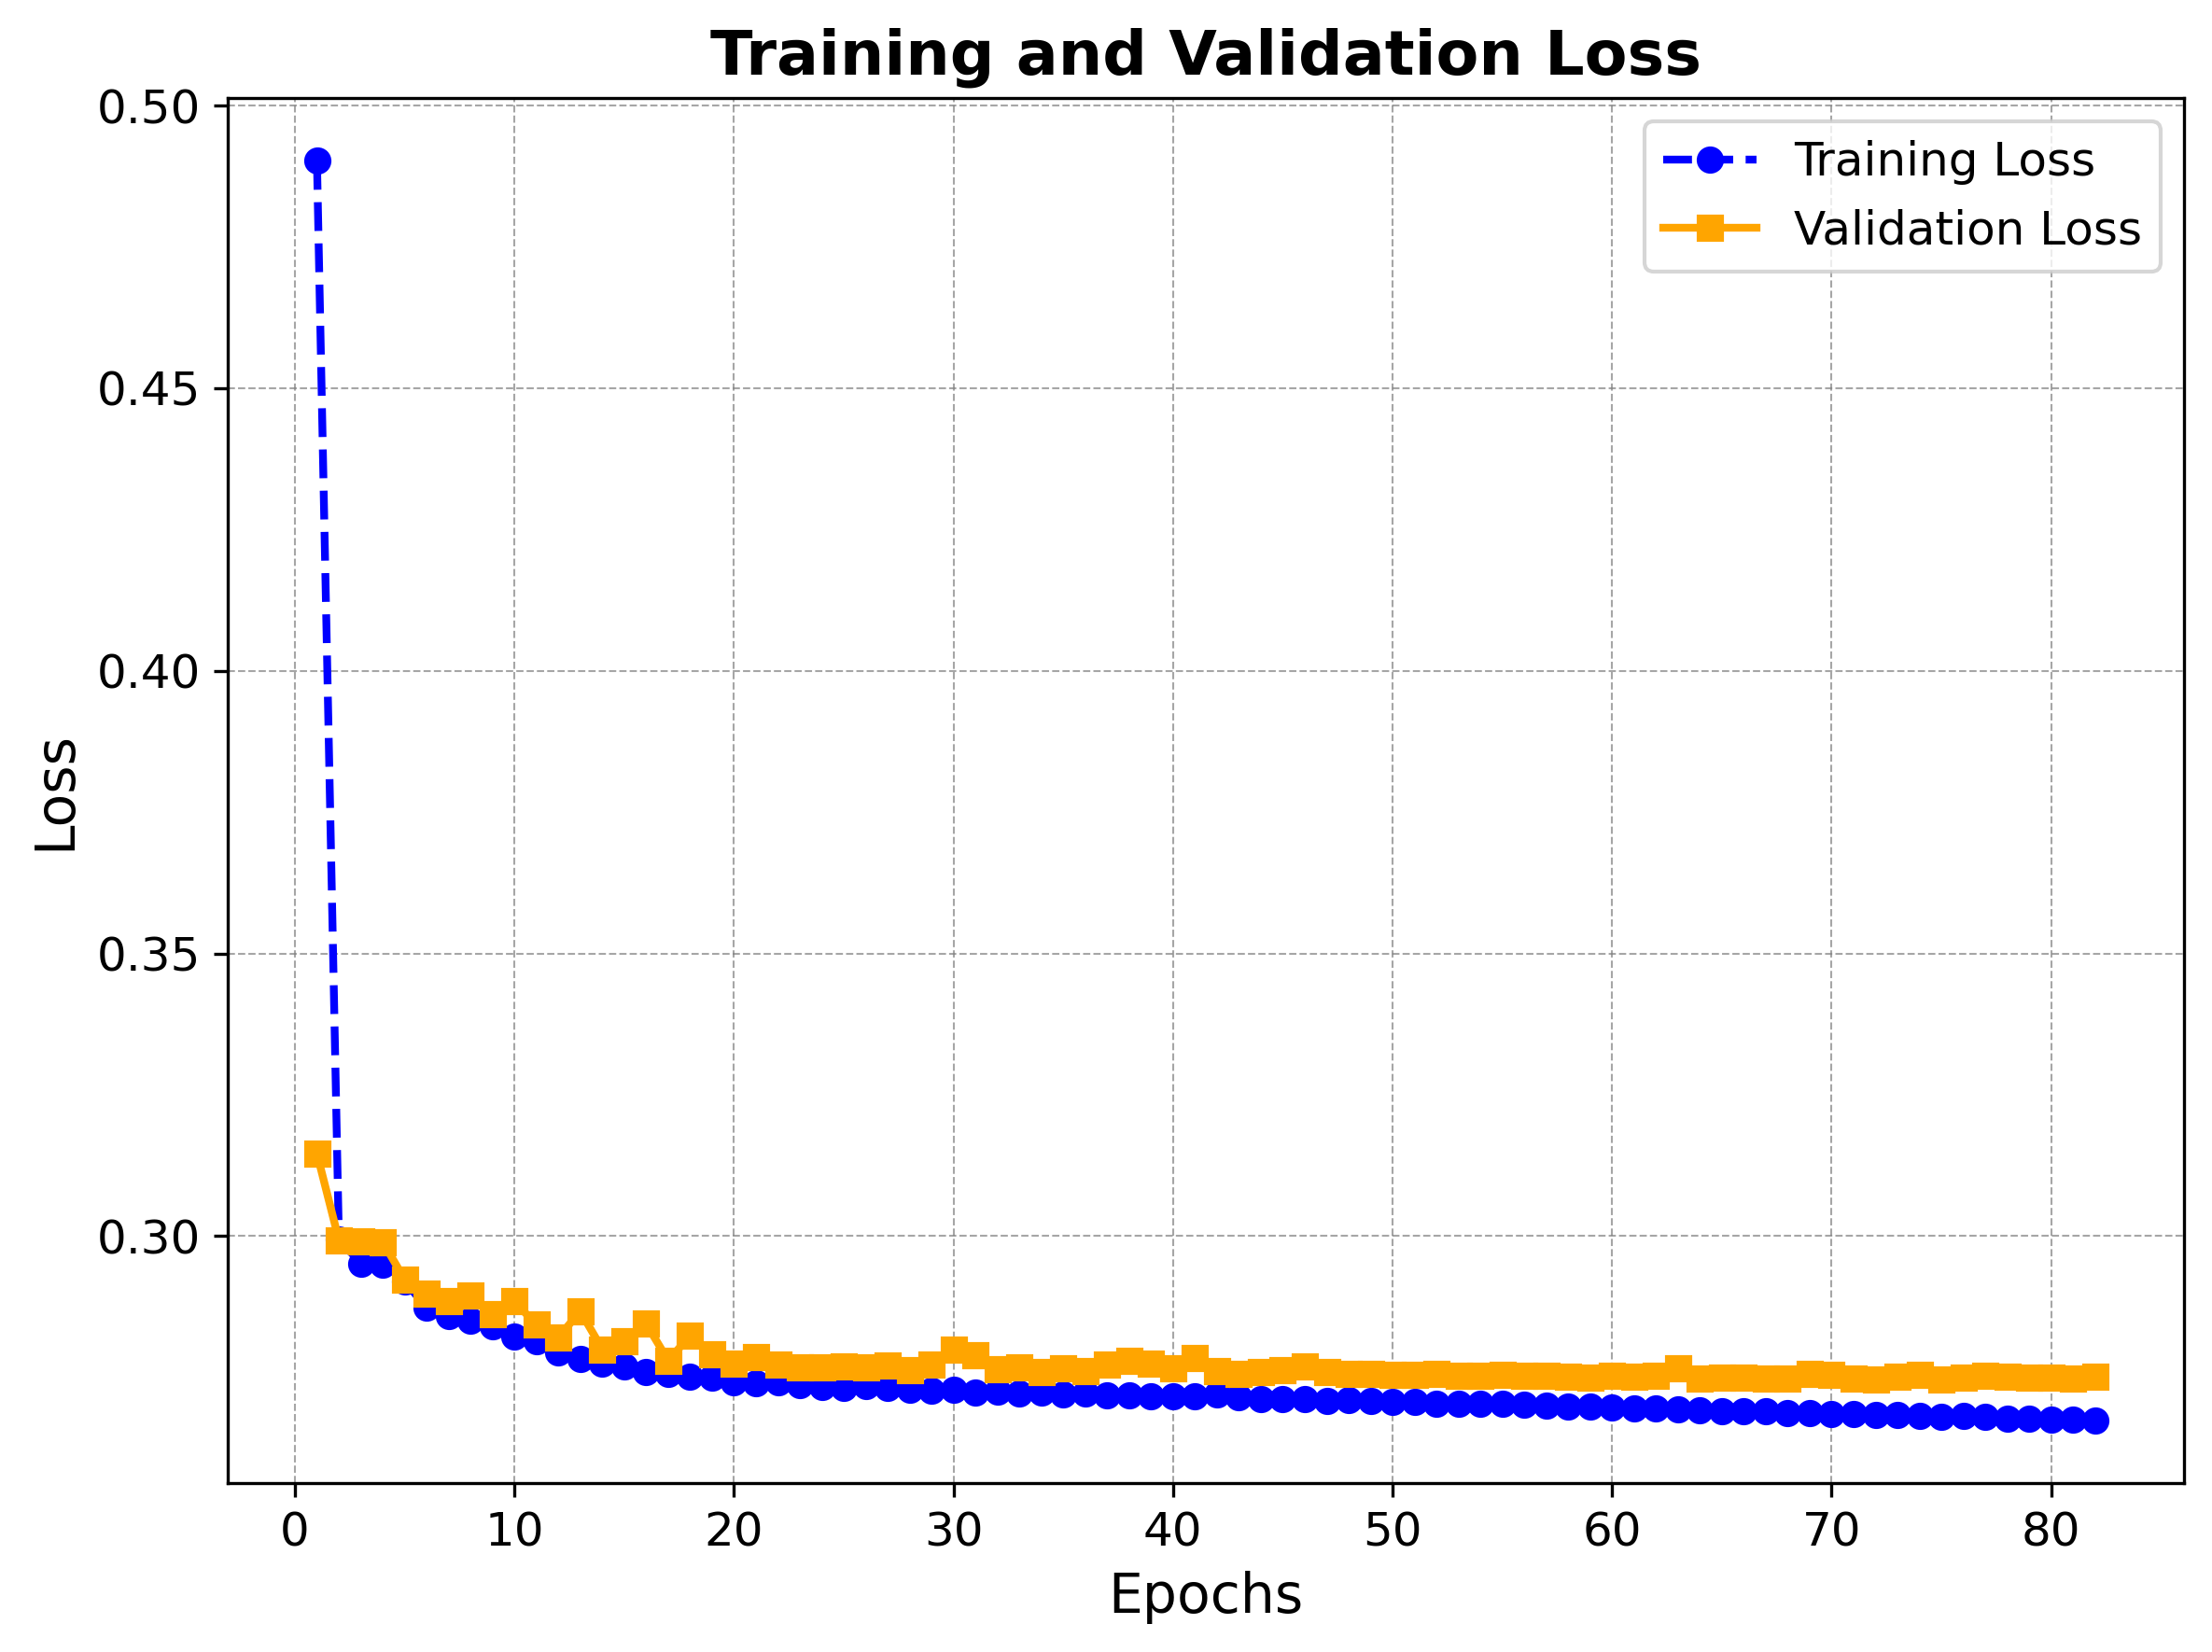

In [73]:
import matplotlib.pyplot as plt


# Extract training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Define epochs
epochs = range(1, len(train_loss) + 1)

# Set the figure size and DPI
plt.figure(figsize=(8, 6), dpi=300)

# Plot the training and validation loss
plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2, linestyle='--', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2, linestyle='-', marker='s')

# Title and axis labels
plt.title('Training and Validation Loss', fontsize=16, weight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Add legend with increased font size
plt.legend(loc='best', fontsize=12)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig('training_validation_loss.png', format='png', dpi=300)  # Save in high resolution
plt.show()


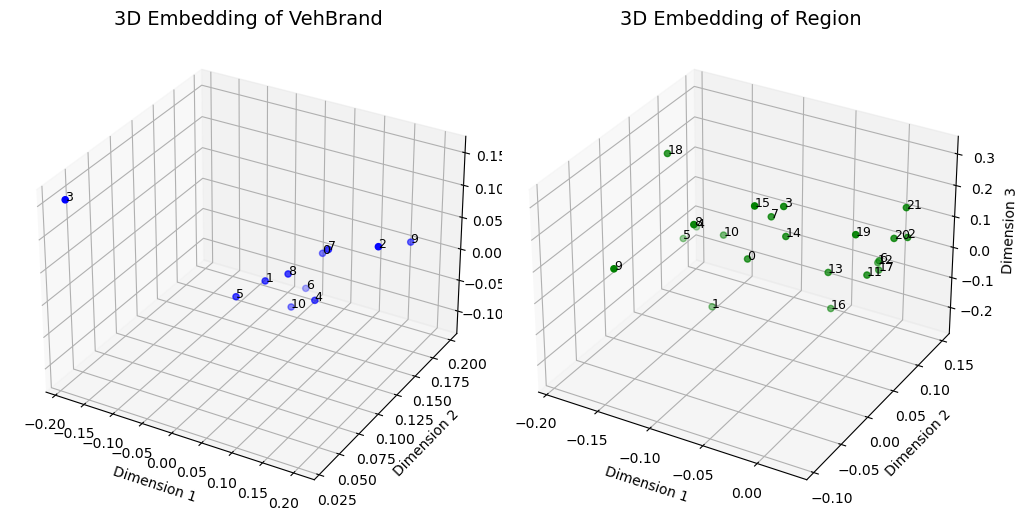

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the embedding weights from the trained model
vehbrand_emb_weights = model.get_layer('BrandEmb').get_weights()[0]
region_emb_weights = model.get_layer('RegionEmb').get_weights()[0]

# Map embeddings to category labels
vehbrand_categories = list(range(len(vehbrand_emb_weights)))  # Assuming categories are 0 to (Brlabel - 1)
region_categories = list(range(len(region_emb_weights)))  # Assuming categories are 0 to (Relabel - 1)

# Plot the 3D embeddings for VehBrand
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(
    vehbrand_emb_weights[:, 0], 
    vehbrand_emb_weights[:, 1], 
    vehbrand_emb_weights[:, 2], 
    color='blue', 
    label='VehBrand'
)
for i, txt in enumerate(vehbrand_categories):
    ax.text(vehbrand_emb_weights[i, 0], vehbrand_emb_weights[i, 1], vehbrand_emb_weights[i, 2], txt, fontsize=9)
ax.set_title('3D Embedding of VehBrand', fontsize=14)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Plot the 3D embeddings for Region
ax = fig.add_subplot(122, projection='3d')
ax.scatter(
    region_emb_weights[:, 0], 
    region_emb_weights[:, 1], 
    region_emb_weights[:, 2], 
    color='green', 
    label='Region'
)
for i, txt in enumerate(region_categories):
    ax.text(region_emb_weights[i, 0], region_emb_weights[i, 1], region_emb_weights[i, 2], txt, fontsize=9)
ax.set_title('3D Embedding of Region', fontsize=14)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

plt.tight_layout()
plt.show()


In [26]:
vehbrand_map

{3: 'B12',
 9: 'B5',
 6: 'B2',
 7: 'B3',
 0: 'B1',
 10: 'B6',
 1: 'B10',
 4: 'B13',
 8: 'B4',
 2: 'B11',
 5: 'B14'}

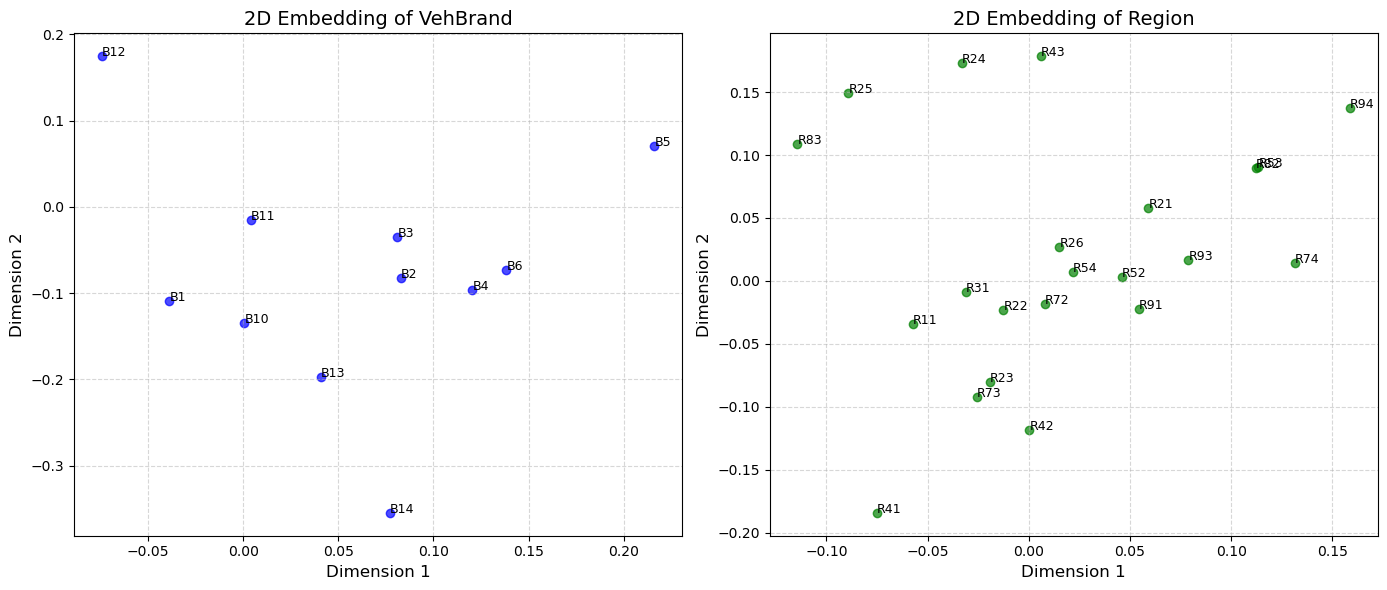

In [116]:
import matplotlib.pyplot as plt
vehbrand_emb_weights = model.get_layer('BrandEmb').get_weights()[0]
region_emb_weights = model.get_layer('RegionEmb').get_weights()[0]
# Reverse mapping: Map the embedding indices back to the original categories
vehbrand_map = {v : k for k, v in learn[['VehBrand', 'VehBrandX']].drop_duplicates().values}
region_map = {v : k for k, v in learn[['Region', 'RegionX']].drop_duplicates().values}

# Adjust categories to handle unmapped indices
vehbrand_categories = [
    vehbrand_map[i] if i in vehbrand_map else f"Unmapped_{i}" for i in range(len(vehbrand_emb_weights))
]
region_categories = [
    region_map[i] if i in region_map else f"Unmapped_{i}" for i in range(len(region_emb_weights))
]

# vehbrand_categories = list(range(len(vehbrand_emb_weights)))  # Assuming categories are 0 to (Brlabel - 1)
# region_categories = list(range(len(region_emb_weights))) 

# Plot the 2D embeddings for VehBrand
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# VehBrand Embedding Plot
ax[0].scatter(
    vehbrand_emb_weights[:, 0], 
    vehbrand_emb_weights[:, 1], 
    color='blue', 
    alpha=0.7, 
    label='VehBrand'
)
for i, txt in enumerate(vehbrand_categories):
    ax[0].text(vehbrand_emb_weights[i, 0], vehbrand_emb_weights[i, 1], txt, fontsize=9)
ax[0].set_title('2D Embedding of VehBrand', fontsize=14)
ax[0].set_xlabel('Dimension 1', fontsize=12)
ax[0].set_ylabel('Dimension 2', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.5)

# Region Embedding Plot
ax[1].scatter(
    region_emb_weights[:, 0], 
    region_emb_weights[:, 1], 
    color='green', 
    alpha=0.7, 
    label='Region'
)
for i, txt in enumerate(region_categories):
    ax[1].text(region_emb_weights[i, 0], region_emb_weights[i, 1], txt, fontsize=9)
ax[1].set_title('2D Embedding of Region', fontsize=14)
ax[1].set_xlabel('Dimension 1', fontsize=12)
ax[1].set_ylabel('Dimension 2', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
learn

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,...,bellGLM,AreaX,VehPowerX,VehAgeX,DrivAgeX,BonusMalusX,VehBrandX,VehGasX,DensityX,RegionX
606711,5025695.0,0,0.07,C,11,0,54,50,B12,Diesel,...,0.012893,-0.2,0.272727,-1.0,0.000000,-1.00,3,-0.5,0.111765,15
331376,2264521.0,0,0.23,C,5,13,39,50,B5,Regular,...,0.010816,-0.2,-0.818182,0.3,-0.416667,-1.00,9,0.5,-0.015686,19
162777,1142905.0,0,1.00,A,7,9,29,54,B2,Diesel,...,0.133205,-1.0,-0.454545,-0.1,-0.694444,-0.92,6,-0.5,-0.549020,4
614094,5047229.0,0,0.10,B,5,1,50,50,B12,Regular,...,0.010230,-0.6,-0.818182,-0.9,-0.111111,-1.00,3,0.5,-0.158824,19
353796,2286944.0,0,0.52,E,6,1,37,51,B3,Diesel,...,0.054218,0.6,-0.636364,-0.9,-0.472222,-0.98,7,-0.5,0.590196,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264934,2129471.0,0,0.09,D,6,13,28,118,B1,Regular,...,0.010220,0.2,-0.636364,0.3,-0.722222,0.36,0,0.5,0.464706,17
477911,3243553.0,0,0.07,E,13,15,35,60,B11,Regular,...,0.003453,0.6,0.636364,0.5,-0.527778,-0.80,2,0.5,0.686275,0
572924,4164101.0,0,0.75,E,11,4,37,68,B14,Diesel,...,0.087906,0.6,0.272727,-0.6,-0.472222,-0.64,5,-0.5,0.550980,20
158853,1134511.0,0,0.73,C,10,3,41,50,B2,Regular,...,0.065080,-0.2,0.090909,-0.7,-0.361111,-1.00,6,0.5,-0.001961,11


In [87]:
learn['VehBrand'].unique()

array(['B12', 'B5', 'B2', 'B3', 'B1', 'B6', 'B10', 'B13', 'B4', 'B11',
       'B14'], dtype=object)

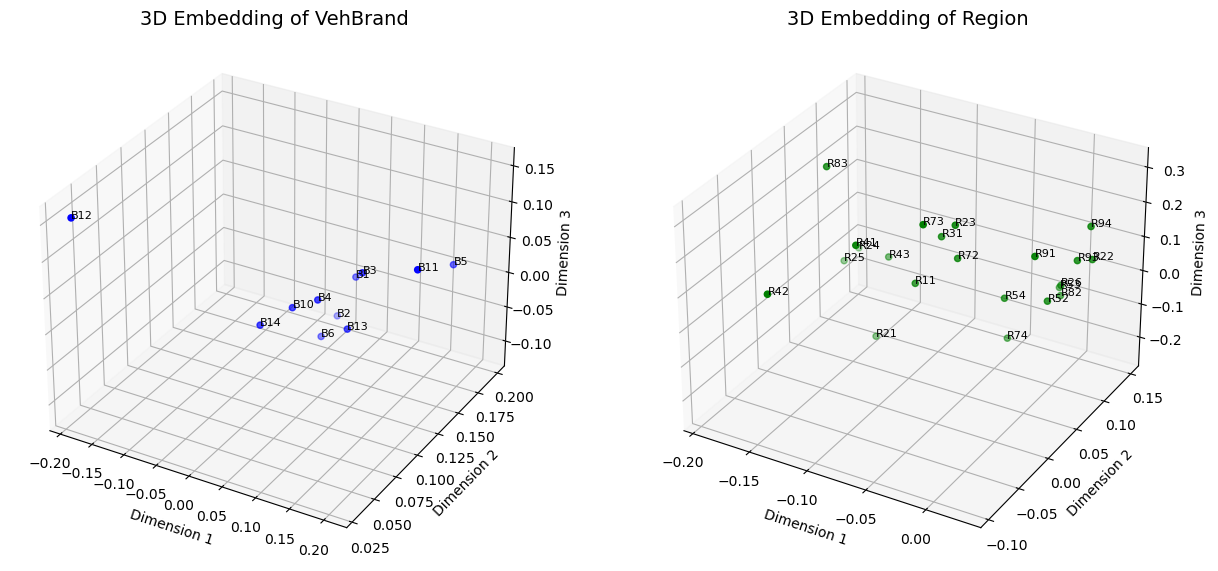

In [44]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Extract the embedding weights from the trained model
# vehbrand_emb_weights = model.get_layer('BrandEmb').get_weights()[0]
# region_emb_weights = model.get_layer('RegionEmb').get_weights()[0]

# # Reverse mapping: Map the embedding indices back to the original categories
# vehbrand_map = {v : k for k, v in learn[['VehBrand', 'VehBrandX']].drop_duplicates().values}
# region_map = {v : k for k, v in learn[['Region', 'RegionX']].drop_duplicates().values}

# # Adjust categories to handle unmapped indices
# vehbrand_categories = [
#     vehbrand_map[i] if i in vehbrand_map else f"B1" for i in range(len(vehbrand_emb_weights))
# ]
# region_categories = [
#     region_map[i] if i in region_map else f"R11" for i in range(len(region_emb_weights))
# ]

# # Plot the 3D embeddings for VehBrand
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(121, projection='3d')
# ax.scatter(
#     vehbrand_emb_weights[:, 0], 
#     vehbrand_emb_weights[:, 1], 
#     vehbrand_emb_weights[:, 2], 
#     color='blue', 
#     label='VehBrand'
# )
# for i, txt in enumerate(vehbrand_categories):
#     ax.text(vehbrand_emb_weights[i, 0], vehbrand_emb_weights[i, 1], vehbrand_emb_weights[i, 2], txt, fontsize=9)
# ax.set_title('3D Embedding of VehBrand', fontsize=14)
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_zlabel('Dimension 3')

# # Plot the 3D embeddings for Region
# ax = fig.add_subplot(122, projection='3d')
# ax.scatter(
#     region_emb_weights[:, 0], 
#     region_emb_weights[:, 1], 
#     region_emb_weights[:, 2], 
#     color='green', 
#     label='Region'
# )
# for i, txt in enumerate(region_categories):
#     ax.text(region_emb_weights[i, 0], region_emb_weights[i, 1], region_emb_weights[i, 2], txt, fontsize=9)
# ax.set_title('3D Embedding of Region', fontsize=14)
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_zlabel('Dimension 3')

# plt.tight_layout()
# plt.show()


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the embedding weights from the trained model
vehbrand_emb_weights = model.get_layer('BrandEmb').get_weights()[0]
region_emb_weights = model.get_layer('RegionEmb').get_weights()[0]

# Reverse mapping: Map the embedding indices back to the original categories
vehbrand_map = {v: k for k, v in learn[['VehBrand', 'VehBrandX']].drop_duplicates().values}
region_map = {v: k for k, v in learn[['Region', 'RegionX']].drop_duplicates().values}

# Adjust categories to handle unmapped indices
vehbrand_categories = [
    vehbrand_map[i] if i in vehbrand_map else f"B1" for i in range(len(vehbrand_emb_weights))
]
region_categories = [
    region_map[i] if i in region_map else f"R11" for i in range(len(region_emb_weights))
]

# Plot the 3D embeddings for VehBrand and Region
fig = plt.figure(figsize=(15, 8))  # Increased figure size
plt.subplots_adjust(wspace=0.2)  # Added space between subplots

# VehBrand plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(
    vehbrand_emb_weights[:, 0],
    vehbrand_emb_weights[:, 1],
    vehbrand_emb_weights[:, 2],
    color='blue',
    label='VehBrand'
)
for i, txt in enumerate(vehbrand_categories):
    ax1.text(
        vehbrand_emb_weights[i, 0],
        vehbrand_emb_weights[i, 1],
        vehbrand_emb_weights[i, 2],
        txt,
        fontsize=8,
        rotation=15  # Slight rotation for better visibility
    )
ax1.set_title('3D Embedding of VehBrand', fontsize=14)
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.set_zlabel('Dimension 3')

# Region plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    region_emb_weights[:, 0],
    region_emb_weights[:, 1],
    region_emb_weights[:, 2],
    color='green',
    label='Region'
)
for i, txt in enumerate(region_categories):
    ax2.text(
        region_emb_weights[i, 0],
        region_emb_weights[i, 1],
        region_emb_weights[i, 2],
        txt,
        fontsize=8,
        rotation=15  # Slight rotation for better visibility
    )
ax2.set_title('3D Embedding of Region', fontsize=14)
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.set_zlabel('Dimension 3')
plt.savefig("embedding_visualization.png", dpi=300, bbox_inches='tight')
plt.show()


In [90]:
learn['Region'].unique()

array(['R73', 'R91', 'R24', 'R93', 'R82', 'R72', 'R11', 'R52', 'R54',
       'R22', 'R94', 'R31', 'R42', 'R23', 'R21', 'R74', 'R53', 'R83',
       'R41', 'R25', 'R26', 'R43'], dtype=object)

In [ ]:
# import pandas as pd

# # Define the columns
# columns = [
#     'index', 'cann', 'd', 'layers', 'neurons', 'alpha', 'epoch', 'effective_epoch','batch', 
#     'patience', 'training_loss', 'testing_data', 'deviance_data', 'portfolio_avg'
# ]

# # Create an empty DataFrame
# df = pd.DataFrame(columns=columns)


In [37]:

# Add an example row
example_row = {
    'index': 15,
    'cann': 0,  # 1 for using CANN, 0 otherwise
    'd': 3,  # Example embedding dimension
    'layers': 5,  # Number of layers in the network
    'neurons': (150, 120, 100, 75, 50, 1),  # Neurons in each layer as a tuple
    'alpha': 0.001,  # Learning rate
    'epoch': 1000,  # Number of epochs
    'effective_epoch': 63,  # Effective epoch
    'batch': 10000,  # Batch size
    'patience': 10,  # Early stopping patience
    'training_loss': training_loss,  # Training loss
    'testing_data': test_loss,  # Testing loss
    'deviance_data': bell_data,  # Deviance loss
    'portfolio_avg': portfolio_avg # Average portfolio value
}

# Append the row to the DataFrame
df = df.append(example_row, ignore_index=True)


In [93]:
df.to_csv('example_data.csv')

In [18]:
df = pd.read_csv('example_data.csv', index_col=0)

In [38]:
df

,index,cann,d,layers,neurons,alpha,epoch,effective_epoch,batch,patience,training_loss,testing_data,deviance_data,portfolio_avg
0,1,1,2,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,82,10000,10,"(0.26822328567504883,)",0.269057,0.268307,0.053186
1,2,1,1,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,72,10000,10,"(0.26922425627708435,)",0.270304,0.270034,0.054766
2,3,1,3,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,51,10000,10,"(0.27103620767593384,)",0.270335,0.270966,0.055915
3,15,0,2,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,63,10000,10,"(0.26967698335647583,)",0.269182,0.405993,0.007305
4,15,0,3,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,63,10000,10,"(0.26912716031074524,)",0.268878,0.408769,0.006977
5,15,0,3,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,63,10000,10,"(0.26837316155433655,)",0.269443,0.400455,0.007696


In [30]:
df

,index,cann,d,layers,neurons,alpha,epoch,effective_epoch,batch,patience,training_loss,testing_data,deviance_data,portfolio_avg
0,1,1,2,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,82,10000,10,"(0.26822328567504883,)",0.269057,0.268307,0.053186
1,2,1,1,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,72,10000,10,"(0.26922425627708435,)",0.270304,0.270034,0.054766
2,3,1,3,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,51,10000,10,"(0.27103620767593384,)",0.270335,0.270966,0.055915
3,15,0,2,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,63,10000,10,"(0.26967698335647583,)",0.269182,0.405993,0.007305
4,15,0,3,5,"(150, 120, 100, 75, 50, 1)",0.001,1000,63,10000,10,"(0.26912716031074524,)",0.268878,0.408769,0.006977
